In [14]:
# Debug RF

from ml4paleo.segmentation import RandomForest3DSegmenter
import pathlib
from config import CONFIG
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

In [12]:
path_to_training = pathlib.Path(CONFIG.training_directory) / "6662F2" 
imgs_fn = sorted(path_to_training.glob(CONFIG.training_img_prefix + "*"))
segs_fn = sorted(path_to_training.glob(CONFIG.training_seg_prefix + "*"))

In [15]:
Xs = [
    # Get greyscale images
    np.array(Image.open(fn).convert("L"))
    for fn in imgs_fn
]

Ys = [
    # Get just the red channel
    np.array(Image.open(fn).convert("RGB"))[:,:,0]
    for fn in segs_fn
]

In [17]:
model = RandomForest3DSegmenter()
X = np.stack(Xs)
Y = np.stack(Ys)

model.fit(X, Y)

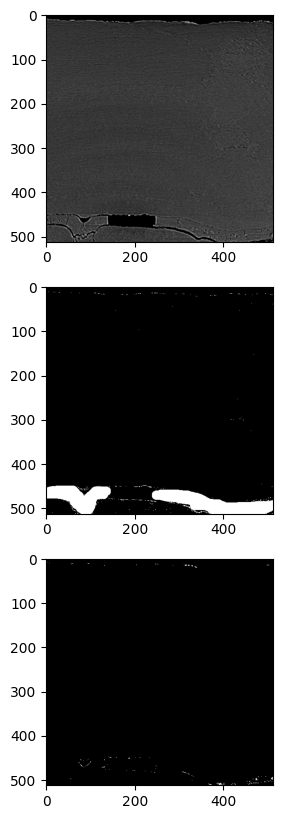

In [21]:
# Draw three subplots:
# Original image
# True Segmentation
# Predicted segmentation
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(Xs[0], cmap="gray")
plt.subplot(    3, 1, 2)
plt.imshow(Ys[0], cmap="gray")
plt.subplot(    3, 1, 3)
plt.imshow(model.segment(np.expand_dims(Xs[0], axis=-1)), cmap="gray")
